# Maxar Image Availability Analysis

The Maxar image availability workflow takes as input a list of TerraFund project ids and returns as output a csv listing every project and how much of that project’s area has Maxar imagery coverage.

#### Workflow:
1. Pull info on project characteristics for the entire portfolio using the TerraMatch API
    - Repo/notebook: terrafund-portfolio-analysis/tm-api.ipynb
    - Input: list of TerraFund project IDs
    - Output: csv of all project features
2. Using the TM API csv, pull Maxar metadata
    - Repo/notebook: maxar-tools/decision-tree-metadata.ipynb and maxar-tools/src/decision_tree.py (? may need to change b/c of my additions to the acquire_metadata function)
    - Input: csv of project features
    - Output: csv of maxar metadata
3. Create imagery features (??)
    - Repo/notebook: terrafund-portfolio-analysis/maxar-img-avail.py
    - Input: csv of maxar metadata and csv of TM project features
    - Output: csv of project features and percent imagery coverage
4. Identify projects with 100% imagery coverage

In [1]:
import pandas as pd # keep
import geopandas as gpd # keep
import numpy as np 
import matplotlib.pyplot as plt
from shapely.geometry import shape # keep
from shapely.geometry import Polygon, Point # keep
from shapely import union_all 
import ast # keep
from datetime import datetime, timedelta # keep datetime
import re
import os
import math 
import requests
import yaml # keep
import json
import pyproj
import sys
sys.path.append('../src/')
import image_availability as img 
import process_api_results as clean
import decision_trees as tree
import tm_api_utils as api_request

%load_ext autoreload
%autoreload 2

### Parameters

In [41]:
# File paths
tm_auth_path = '../secrets.yaml'
tm_staging_url = "https://api-staging.terramatch.org/research/v3/sitePolygons?"                 # use for testing queries
tm_prod_url = "https://api.terramatch.org/research/v3/sitePolygons?"                            # Use to pull data for analysis'
approved_projects = '../terrafund-portfolio-analyses/projects_all_approved_202501091214.csv'    # List of projects with approved polygons
feats = '../data/tm_api_TEST.csv'                                                               # Polygon metadata & geometries from TM API
maxar_feats = '/home/darby/github_repos/maxar-tools/data/tm_api_TEST.csv'                       # Polygon metadata & geometries from TM API saved to maxar-tools repo
maxar_md = '../data/imagery_availability/comb_img_availability_2025-02-26.csv'                  # Metadata for Maxar images corresponding to polygons
results_path = '../data/results/'                                                                               # File path to save results to

# Define filtering thesholds (stored in a dictionary)
filters = {
    'cloud_cover': 50,          # Remove images with >50% cloud cover
    'off_nadir': 30,            # Remove images with >30° off-nadir angle
    'sun_elevation': 30,        # Keep only images where sun elevation >30°
    'date_range': (-366, 0),    # Date range of 1 year before plantstart
    'img_count': 1,             # Threshold for identifying image availability (REASSESS)
    'ev_range': (730,1095)      # Early verification window (2-3 years after plantstart date) (REASSESS)
}

## Code Workflow Outline (DON'T RUN!!)

In [ ]:
# Step 1: LOAD AND PREPROCESS DATA
# 1.1: Load polygon dataset
poly_csv = gpd.GeoDataFrame(polygon geometries & metadata)

# 1.2 Load image dataset
img_csv = gpd.GeoDataFrame(maxar image geometries & metadata)

# 1.3 Preprocess the data
poly_gdf = preprocess_polygons(poly_csv) # Clean data, convert geometries, enforce CRS
img_gdf = preprocess_images(img_csv) # Clean data, convert geometries, enforce CRS


# Step 2: MERGE POLYGON DATA WITH IMAGE DATA
merged_gdf = img_gdf.merge(poly_gdf, on=['project_id', 'poly_id'], how='left')

# Step 3: PRE-FILTER IMAGES
filtered_images = merged_gdf where:
    (date is within allowed date range) &
    (cloud cover < cloud_thresh) &
    (off-nadir angle < off_nadir_thresh) &
    (sun elevation < sun_elev_thresh)

# Step 4: ITERATE THROUGH PROJECTS AND POLYGONS TO CALCULATE IMAGERY COVERAGE
# 4.1 Create a dictionary for project-polygon mapping
project_polygons = {project_id: list of poly_ids associated with that project} # Create a dictionary

# 4.2 Initialize list to store low coverage cases
low_img_coverage_log = []

# 4.3 Iterate through each project
for each project_id in project_polygons:

    # 4.4 Get all polygons for this project
    project_polygons_list = list of poly_ids for this project_id

    # 4.5 Iterate through each polygon in the project
    for each poly_id in project_polygons_list:
    
        # 4.6 Get all images associated with this polygon
        poly_images = filtered_images[filtered_images['poly_id'] == poly_id]

        # Count the number of available images
        num_images = len(poly_images)

        # If no valid image exists, record 0% coverage
        if poly_images is empty:
            store result: (poly_id, project_id, None, num_images, 0, 0) # No images available
            continue

        # 4.7 Select the best image (lowest cloud cover)
        best_image = select_best_image(poly_images)

        # 4.8 Get polygon and image geometries
        poly_geom = poly_gdf[poly_gdf['poly_id'] == poly_id].geometry.iloc[0]
        best_img_geom = best_image['img_geom']

        # 4.9 Compute UTM Zone and reproject geometries
        poly_centroid = compute centroid of poly_geom
        utm_crs = get UTM CRS from centroid
        poly_geom_reprojected = reproject poly_geom to utm_crs
        best_img_geom_reprojected = reproject best_img_geom to utm_crs

        # 4.10 Calculate the polygon area dynamically (in hectares)
        poly_area_ha = poly_geom_reprojected.area / 10000

        # 4.11 Calculate area of overlap
        overlap_area = poly_geom_reprojected union best_img_geom_reprojected
        overlap_area_ha = overlap_area / 10000

        # 4.12 Compute percent of polygon area covered
        percent_img_cover = (overlap_area / poly_area_ha) * 100

        # 4.13 Log cases where imagery coverage is unexpectedly low
        if percent_img_cover < 50:
            log_entry = {
                'poly_id': poly_id,
                'project_id': project_id,
                'best_image': best_image['title'],
                'num_images': num_images,
                'poly_area_ha': poly_area_ha,
                'overlap_area_ha': overlap_area_ha,
                'percent_img_cover': percent_img_cover
            }
            low_img_coverage_log.append(log_entry)

        # 4.14 Store results
        store result: (poly_id, project_id, best_image['title'], num_images, poly_area_ha, overlap_area_ha, percent_img_cover)

# STEP 5: EXPORT LOW COVERAGE LOG IF NEEDED
if low_img_coverage_log is not empty:
    export_to_csv(low_img_coverage_log, "low_coverage_polygons.csv")

# Function Implementation

### STEP 1: LOAD & PREPROCESS DATA
Goal: ensure input data is clean & structured

In [43]:
## 1.1 LOAD IN POLYGON AND IMAGE CSVS
poly_df = pd.read_csv(feats)
img_df = pd.read_csv(maxar_md)

In [3]:
## 1.2 PREPROCESS POLYGON DATA
def preprocess_polygons(poly_df, debug=False):
    """
    Cleans up a dataframe of polygon metadata & geometries from the TerraMatch API and 
    converts it into a GeoDataframe

    Args:
        poly_df (DataFrame): Raw polygon dataset.

    Returns:
        GeoDataFrame: Processed polygon dataset with a geometry column as a shapely object.
    """
    # Enforce lowercase column names
    poly_df.columns = poly_df.columns.str.lower()

    # Rename 'name' and 'geometry' columns
    poly_df = poly_df.rename(columns={'name': 'poly_name', 'geometry': 'poly_geom'})

    # Convert 'plantstart' column to a datetime
    poly_df['plantstart'] = pd.to_datetime(poly_df['plantstart'], errors='coerce')

    # Convert stringified 'poly_geom' dictionaries into real dictionaries
    poly_df['poly_geom'] = poly_df['poly_geom'].apply(lambda x: shape(ast.literal_eval(x)) if isinstance(x, str) else shape(x))

    # Convert 'poly_geom' dictionaries from WKT to Shapely objects
    poly_df['poly_geom'] = poly_df['poly_geom'].apply(shape)

    # Convert to GeoDataFrame
    poly_gdf = gpd.GeoDataFrame(poly_df, geometry='poly_geom', crs="EPSG:4326")

    # Add a field for the polygon centroid
    poly_gdf['poly_centroid'] = poly_gdf['poly_geom'].iloc[0].centroid

    if debug:
        print(f"There are {len(poly_gdf.poly_id.unique())} unique polygons for {len(poly_gdf.project_id.unique())} projects in this dataset.")

    return poly_gdf

In [4]:
## 1.3 PREPROCESS MAXAR IMAGERY DATA
def preprocess_images(img_df, debug=True):
    """
    Cleans up a dataframe of maxar image metadata & geometries from the Maxar Discovery API and 
    converts it into a GeoDataframe

    Args:
        img_df (DataFrame): Raw image metadata dataset.
    
    Returns: 
        GeoDataFrame: Processed image dataset with a geometry column as a shapely object.
    """
    # Convert 'datetime' column to a datetime and rename
    img_df.loc[:, 'datetime'] = pd.to_datetime(img_df['datetime'], format='%Y-%m-%dT%H:%M:%S.%fZ', errors='coerce') # Convert to datetime type
    img_df.loc[:, 'datetime'] = img_df['datetime'].apply(lambda x: x.replace(tzinfo=None) if pd.notna(x) else x)    # Remove time zone info
    
    # Rename the 'datetime' column to 'img_date'
    img_df = img_df.rename(columns={'datetime': 'img_date'}) # Rename the column img_date

    # Select the relevent columns from img_df
    img_df = img_df[['title', 'project_id', 'poly_id', 'img_date', 'area:cloud_cover_percentage', 'eo:cloud_cover', 'area:avg_off_nadir_angle', 'view:sun_elevation', 'img_geom']]

    # Convert stringified 'poly_geom' dictionaries into real dictionaries
    img_df['img_geom'] = img_df['img_geom'].apply(lambda x: shape(ast.literal_eval(x)) if isinstance(x, str) else shape(x))

    # Convert 'img_geom' (image footprint geometries) from WKT to Shapely objects
    img_df['img_geom'] = img_df['img_geom'].apply(shape)

    # Convert DataFrame to GeoDataFrame
    img_gdf = gpd.GeoDataFrame(img_df, geometry='img_geom', crs="EPSG:4326")

    # Add a field for the image centroid
    img_gdf['img_centroid'] = img_gdf['img_geom'].iloc[0].centroid

    if debug:
        print(f"There are {len(img_gdf)} images for {len(img_gdf.poly_id.unique())} polygons in {len(img_gdf.project_id.unique())} projects in this dataset.")

    return img_gdf

### STEP 2: MERGE & FILTER DATA
Goal: link images to polygons and apply filters

In [ ]:
## 2.1 MERGE THE POLYGON ATTRIBUTES TO THE IMAGES GEODATAFRAME
def merge_polygons_images(img_gdf, poly_gdf, debug=True):
    """ 
    Merges the polygon metadata into the Maxar image GeoDataFrame. All rows of the img_gdf are preserved.
    Also records polygons that are dropped because they don't have any associated images.

    Args:
        img_gdf (GeoDataFrame): Image metadata dataset (each row represents a Maxar image)
        poly_gdf (GeoDataFrame): Polygon dataset (each row represents a polygon from the TM API)
    
    Returns:
        tuple: (GeoDataFrame of merged dataset, list of missing polygons (poly_id, project_id))
    """
    # Merge the image data with the polygon data (preserving image data rows and adding associated polygon attributes)
    merged_gdf = img_gdf.merge(poly_gdf, on=['project_id', 'poly_id'], how='left')

    # Identify polygons without any corresponding Maxar images
    missing_polygons_df = poly_gdf[~poly_gdf['poly_id'].isin(merged_gdf['poly_id'])]

    # Save poly_id and project_id of missing polygons as a list of tuples
    missing_polygons_list = list(missing_polygons_df[['poly_id', 'project_id']].itertuples(index=False, name=None))

    if debug:
        print(f"Total images in img_gdf: {len(img_gdf)}")
        print(f"Total polygons in poly_gdf: {len(poly_gdf)}")
        print(f"Total rows in merged dataset: {len(merged_gdf)}")
        print(f"Unique polygons in merged dataset: {len(merged_gdf['poly_id'].unique())}")
    
        # Count polygons dropped due to no matching images
        missing_polygons = len(poly_gdf[~poly_gdf['poly_id'].isin(merged_gdf['poly_id'])])
        print(f"There {missing_polygons} polygons without images in the merged dataset")
        print(f"Polygons without images (dropped at this stage): {missing_polygons_list}")

    return merged_gdf, missing_polygons_list

In [16]:
### 2.2 FILTER IMAGES BASED ON HARD CRITERIA
def filter_images(merged_gd, filters, debug=True):
    """
    Filters the merged dataset to retain only images that meet filters for image quality.
    The values for the filters can be changed in the parameters section.

    Args:
        merged_gdf (GeoDataFrame): Merged dataset of images and polygons.
        filters (dict): Dictionary containing filter thresholds (in Parameters section of notebook)
    
    Returns:
        GeoDataFrame: Filtered dataset containing only the images that meet the criteria
    """
    # Ensure date columns are in correct datetime format
    merged_gdf['img_date'] = pd.to_datetime(merged_gdf['img_date'], errors='coerce')
    merged_gdf['plantstart'] = pd.to_datetime(merged_gdf['plantstart'], errors='coerce')

    # Compute the date difference (image capture date - plant start date)
    merged_gdf['date_diff'] = (merged_gdf['img_date'] - merged_gdf['plantstart']).dt.days

    # Apply filtering criteria to retain only images within the desired time range, cloud cover, 
    # off nadir angle, and sun elevation parameters
    filtered_images = merged_gdf[
        (merged_gdf['date_diff'] >= filters['date_range'][0]) &
        (merged_gdf['date_diff'] <= filters['date_range'][1]) &
        (merged_gdf['area:cloud_cover_percentage'] < filters['cloud_cover']) &
        (merged_gdf['area:avg_off_nadir_angle'] <= filters['off_nadir']) &
        (merged_gdf['view:sun_elevation'] >= filters['sun_elevation'])
    ].copy()  # Copy to avoid SettingWithCopyWarning

    if debug:
        print(f"Total images before filtering: {len(merged_gdf)}")
        print(f"Total images after filtering: {len(filtered_images)}")
        print(f"Polygons with at least one valid image: {filtered_images['poly_id'].nunique()}")

    return filtered_images

### STEP 3: PROCESS EACH POLYGON & COMPUTE IMAGERY COVERAGE
Goal: Prepare polygons, select the best image, and calculate imagery coverage per polygon

In [7]:
## 3.1 GET THE BEST IMAGE FOR A GIVEN POLYGON
def get_best_image(poly_images, debug=False):
    """
    Selects the best image for a given polygon based on the lowest cloud cover. If multiple images have
    the same cloud cover, selects the one closest to the plantstart date. 

    If we want to update this to include an "expected coverage" based on cloud cover and footprint overlap,
    this is where it would go.

    Args:
        poly_images (GeoDataFrame): Subset of img_gdf_filtered containing images for one polygon.
    
    Returns:
        GeoSeries: The best image row from poly_images
    """
    # Create an absolute value date_diff column to help sort images by proximity to plantstart date
    poly_images = poly_images.copy() # Avoid modifying the original dataframe
    poly_images['abs_date_diff'] = poly_images['date_diff'].abs()

    # Sort images by cloud cover (ascending) and then by date (closest to plantstart)
    sorted_images = poly_images.sort_values(by=['area:cloud_cover_percentage', 'abs_date_diff'])

    if debug:
        print("\n Debug: Sorted images for this polygon (using cloud cover, then proximity to plantstart date):")
        print(sorted_images[['title', 'area:cloud_cover_percentage', 'img_date', 'plantstart', 'abs_date_diff']])

    # Select the best image (first row after sorting)
    best_image = sorted_images.iloc[0]

    return best_image

In [8]:
## 3.2 GET THE APPROPRIATE UTM CRS FOR A POLYGON BASED ON ITS CENTROID
def get_utm_crs(longitude, latitude):
    """
    Determines the appropriate UTM CRS for a given polygon based on the longitude and latitude
    of its centroid.

    Args:
        longitude (float): Longitude of the polygon centroid.
        latitude (float): Latitude of the polygon centroid.
    
    Returns:
        str: EPSG code of the best UTM CRS.
    """

    # UTM zones range from 0 to 60, each covering 6 degrees of longitude
    utm_zone = int((longitude + 180) / 6) + 1

    # EPSG code for UTM Northern vs. Southern hemisphere
    epsg_code = 32600 + utm_zone if latitude >= 0 else 32700 + utm_zone

    return f"EPSG:{epsg_code}"

In [22]:
## 3.3 COMPUTE THE IMAGERY COVERAGE FOR A GIVEN POLYGON
def compute_polygon_image_coverage(poly_id, project_id, poly_gdf, img_gdf_filtered,
                                   low_img_coverage_log, min_coverage_threshold=50):
    """
    Computes the percentage of a polygon's area that is covered by its best available Maxar image.

    Args:
        poly_id (str): Unique polygon ID
        project_id (str): Unique project ID
        poly_gdf (GeoDataFrame): Polygons dataset
        img_gdf_filtered (GeoDataFrame): Images dataset filtered by hard criteria
        low_img_coverage_log (list): List to store cases where imagery coverage is low
        min_coverage_threshold (int): Imagery coverage threshold below which polygons are logged

    Returns:
        Tuple containing (poly_id, project_id, best_image, num_images, poly_area_ha,
        overlap_area_ha, percent_img_cover)
    """

    # Get all images associated with this polygon
    print(f"Computing coverage for polygon {poly_id}")
    poly_images = img_gdf_filtered[img_gdf_filtered['poly_id'] == poly_id]
    num_images = len(poly_images)

    # If no valid images, log the case and return 0% imagery coverage
    if poly_images.empty:
        log_entry = {
            'poly_id': poly_id,
            'project_id': project_id,
            'best_image': None,
            'num_images': 0,
            'poly_area_ha': 0,
            'overlap_area_ha': 0,
            'percent_img_cover': 0,
        }
        print(f"Logging low covarage for polygon {poly_id} because there is no available imagery")
        low_img_coverage_log.append(log_entry)

        # Return after logging
        return (poly_id, project_id, None, num_images, 0, 0, 0)
    
    # If there is at least one valid image
    # Select the best image from the filtered images for the polygon
    best_image = get_best_image(poly_images)

    # Explicitly retrieve the polygon row
    polygon_row = poly_gdf.loc[poly_gdf['poly_id'] == poly_id]

    # Retrieve actual polygon and best image footprint geometries
    poly_geom = polygon_row['poly_geom'].values[0]
    best_image_geom = best_image['img_geom']

    # Compute UTM Zone based on polygon centroid and reproject polygon and image footprint
    poly_centroid = poly_geom.centroid
    utm_crs = get_utm_crs(poly_centroid.x, poly_centroid.y)
    
    # Properly reproject both the polygon and image geometries
    poly_reprojected = gpd.GeoDataFrame(polygon_row, geometry='poly_geom', crs="EPSG:4326").to_crs(utm_crs)
    poly_geom_reprojected = poly_reprojected.geometry.iloc[0] # Extract reprojected polygon

    best_img_reprojected = gpd.GeoDataFrame([best_image], geometry="img_geom", crs="EPSG:4326").to_crs(utm_crs)
    best_img_geom_reprojected = best_img_reprojected.geometry.iloc[0]

    # Calculate polygon area dynamically (in hectares)
    poly_area_ha = poly_geom_reprojected.area / 10_000

    # Compute intersection between polygon geometry and best image's footprint geometry
    overlap_area = poly_geom_reprojected.intersection(best_img_geom_reprojected).area
    overlap_area_ha = overlap_area / 10_000

    # Compute percentage of polygon covered by best image
    percent_img_cover = (overlap_area_ha / poly_area_ha) * 100

    # Log cases where the imagery coverage is below the threshold
    if percent_img_cover < min_coverage_threshold or percent_img_cover == 0:
        print(f"Logging low coverage for polygon {poly_id}: {percent_img_cover}%")
        log_entry = {
            'poly_id': poly_id,
            'project_id': project_id,
            'best_image': best_image['title'] if best_image is not None else None,
            'num_images': num_images,
            'poly_area_ha': poly_area_ha,
            'overlap_area_ha': overlap_area_ha,
            'percent_img_cover': percent_img_cover,
        }
        low_img_coverage_log.append(log_entry)

    # Return results
    return (poly_id, project_id, best_image['title'], num_images, poly_area_ha, overlap_area_ha,
            percent_img_cover)

### STEP 4: COMPUTE COVERAGE
Goal: calculate imagery coverage per polygon

### STEP 5: EXPORT RESULTS
Goal: save results for review

# TESTING

In [47]:
## 1.1 LOAD IN POLYGON AND IMAGE CSVS
poly_df = pd.read_csv(feats)
img_df = pd.read_csv(maxar_md)

poly_df.tail()

,name,status,siteid,geometry,plantstart,plantend,practice,targetsys,distr,numtrees,calcarea,indicators,establishmenttreespecies,reportingperiods,poly_id,project_id
17,Nyamirama 2 23B,approved,59816e84-9bae-49c2-a493-1a91ec6e2781,"{'type': 'Polygon', 'coordinates': [[[30.45831...",3/15/2023,NaN,Null,agroforest,Null,NaN,23.495360,"[{'indicatorSlug': 'restorationByLandUse', 'ye...",[],"[{'dueAt': '2023-01-31T00:00:00.000Z', 'submit...",a94b492f-bc97-4dc5-a2ce-569a40e5f102,f81c1422-025c-45b1-a2e1-d354177523ca
18,Nyamirama 2 22A (new),approved,59816e84-9bae-49c2-a493-1a91ec6e2781,"{'type': 'Polygon', 'coordinates': [[[30.45416...",8/11/2022,NaN,tree-planting,agroforest,Null,NaN,45.087196,"[{'indicatorSlug': 'restorationByStrategy', 'y...",[],"[{'dueAt': '2023-01-31T00:00:00.000Z', 'submit...",80495a6a-379c-4a7f-b1dc-16f228beecfe,f81c1422-025c-45b1-a2e1-d354177523ca
19,GouanekÃ© Diarra,approved,727b8223-8082-4d5b-97be-3da87b654f5e,"{'type': 'Polygon', 'coordinates': [[[-8.12907...",NaN,NaN,assisted-natural-regeneration,natural-forest,NaN,NaN,1.226780,"[{'indicatorSlug': 'restorationByStrategy', 'y...",[],"[{'dueAt': '2022-09-30T00:00:00.000Z', 'submit...",b3ea94c2-651c-4181-8786-1ffac8218f9f,684fb6a6-db3c-403a-8bb5-1b90c4234ace
20,Issa Coulibaly,approved,d3ce2f9b-385a-4680-bbcf-31378e72d22a,"{'type': 'Polygon', 'coordinates': [[[-7.81567...",NaN,NaN,tree-planting,agroforest,NaN,NaN,1.395228,"[{'indicatorSlug': 'restorationByStrategy', 'y...",[],"[{'dueAt': '2022-09-30T00:00:00.000Z', 'submit...",71fcca6c-5fdc-402e-9aac-e984bf08d64f,684fb6a6-db3c-403a-8bb5-1b90c4234ace
21,Ba Dognon Diarra,approved,90c9663c-19a6-4905-a563-36460f193fb7,"{'type': 'Polygon', 'coordinates': [[[-8.08345...",NaN,NaN,tree-planting,agroforest,NaN,NaN,2.307911,"[{'indicatorSlug': 'restorationByStrategy', 'y...",[],"[{'dueAt': '2022-09-30T00:00:00.000Z', 'submit...",e317733a-c169-4622-a38f-42454895bcda,684fb6a6-db3c-403a-8bb5-1b90c4234ace


In [48]:
## 1.2 PREPROCESS POLYGON DATA
poly_gdf = preprocess_polygons(poly_df, debug=True)

There are 22 unique polygons for 5 projects in this dataset.


In [49]:
## 1.2 PREPROCESS POLYGON DATA
img_gdf = preprocess_images(img_df, debug=True)

There are 229 images for 16 polygons in 3 projects in this dataset.


In [50]:
## 2.1 MERGE THE POLYGON ATTRIBUTES TO THE IMAGES GEODATAFRAME
merged_gdf, missing_polygons = merge_polygons_images(img_gdf, poly_gdf, debug=True)

Total images in img_gdf: 229
Total polygons in poly_gdf: 22
Total rows in merged dataset: 229
Unique polygons in merged dataset: 16
There 6 polygons without images in the merged dataset
Polygons without images (dropped at this stage): [('d78285b6-1d61-490a-a82b-112ff80998c0', 'f81c1422-025c-45b1-a2e1-d354177523ca'), ('a94b492f-bc97-4dc5-a2ce-569a40e5f102', 'f81c1422-025c-45b1-a2e1-d354177523ca'), ('80495a6a-379c-4a7f-b1dc-16f228beecfe', 'f81c1422-025c-45b1-a2e1-d354177523ca'), ('b3ea94c2-651c-4181-8786-1ffac8218f9f', '684fb6a6-db3c-403a-8bb5-1b90c4234ace'), ('71fcca6c-5fdc-402e-9aac-e984bf08d64f', '684fb6a6-db3c-403a-8bb5-1b90c4234ace'), ('e317733a-c169-4622-a38f-42454895bcda', '684fb6a6-db3c-403a-8bb5-1b90c4234ace')]


In [17]:
### 3.1 FILTER IMAGES BASED ON HARD CRITERIA
img_gdf_filtered = filter_images(merged_gdf, filters, debug=True)

Total images before filtering: 229
Total images after filtering: 30
Polygons with at least one valid image: 15


In [19]:
# Test cases: longitude, latitude → expected UTM zone and EPSG code
test_coords = [
    (-75, 40),   # Philadelphia, USA (Should be EPSG:32618)
    (2.35, 48.85), # Paris, France (Should be EPSG:32631)
    (120, -10),  # Indonesia (Southern Hemisphere, Should be EPSG:32751)
    (-122, 37),  # San Francisco, USA (Should be EPSG:32610)
    (35, 0),     # Near Equator (Should be EPSG:32636)
]

In [20]:
# Run the function on test coordinates
for lon, lat in test_coords:
    utm_crs = get_utm_crs(lon, lat)
    print(f"Longitude: {lon}, Latitude: {lat} → UTM CRS: {utm_crs}")

Longitude: -75, Latitude: 40 → UTM CRS: EPSG:32618
Longitude: 2.35, Latitude: 48.85 → UTM CRS: EPSG:32631
Longitude: 120, Latitude: -10 → UTM CRS: EPSG:32751
Longitude: -122, Latitude: 37 → UTM CRS: EPSG:32610
Longitude: 35, Latitude: 0 → UTM CRS: EPSG:32636


In [32]:
# TEST COMPUTE POLYGON IMAGE COVERAGE
# Initialize storage for results & low-coverage polygons list
low_img_coverage_log = []
results = []

# Iterate through all polygons and compute imagery coverage per polygon
for poly_id, project_id in zip(poly_gdf['poly_id'], poly_gdf['project_id']):
    result = compute_polygon_image_coverage(poly_id, project_id, poly_gdf, img_gdf_filtered, low_img_coverage_log)
    #print("Low Image Coverage Log Contents:", low_img_coverage_log)
    results.append(result)

# Convert the results to a DataFrame
results_df = pd.DataFrame(results, columns=['poly_id', 'project_id', 'best_image', 'num_images',
                                            'poly_area_ha', 'overlap_area_ha', 'percent_img_cover'])

# Convert low-coverage log to DataFrame
low_coverage_polygons_df = pd.DataFrame(low_img_coverage_log)

# Print summary
print(f"Processed {len(results_df)} polygons.")
print(f"{len(low_coverage_polygons_df)} polygons logged as low imagery coverage.")

results_df.tail()

Computing coverage for polygon a91435c7-a179-4c1d-9891-de0fe1741654
Computing coverage for polygon 410696dc-9579-4412-9c7b-55194cb1867c
Computing coverage for polygon f6871a61-a766-451a-be90-086219616cef
Computing coverage for polygon 9e745667-0701-434a-8ecb-d917fe2bcf29
Computing coverage for polygon 9e508b07-4534-4e04-bb5b-bb0d3734a796
Computing coverage for polygon 1cbca6da-0024-47dc-bb3a-06f8727d1cd6
Computing coverage for polygon e7223a4d-68c6-4d32-b140-f871dec62bd3
Computing coverage for polygon 0b9ef620-327a-4be2-8b0c-50ec0fa06788
Computing coverage for polygon e7e42658-360a-4452-8be4-60ea8d1ef0e7
Computing coverage for polygon e18c2562-7f73-4fd2-a361-a6eee01ed71a
Computing coverage for polygon 4d13b994-be20-4392-9f0f-68709607e96b
Computing coverage for polygon c9b59851-e4b7-4271-ac99-f4e601f86e85
Computing coverage for polygon 212d5966-2c94-4db7-98e9-4847cfdc4215
Computing coverage for polygon 8bc43765-9e53-4702-ba97-13005b806126
Computing coverage for polygon e41e8d8a-efa3-462

,poly_id,project_id,best_image,num_images,poly_area_ha,overlap_area_ha,percent_img_cover
11,c9b59851-e4b7-4271-ac99-f4e601f86e85,3a860077-df4c-4e95-8fec-41520c551243,Maxar WV03 Image 1040010068D32900,2,5.644608,5.644608,100.0
12,212d5966-2c94-4db7-98e9-4847cfdc4215,3a860077-df4c-4e95-8fec-41520c551243,Maxar WV02 Image 10300100C00E8900,3,2.293858,2.293858,100.0
13,8bc43765-9e53-4702-ba97-13005b806126,3a860077-df4c-4e95-8fec-41520c551243,Maxar WV02 Image 10300100B3A8FB00,2,14.707241,14.707241,100.0
14,e41e8d8a-efa3-4626-bbfe-5af48f23b6da,529e1bae-2187-473f-a2a3-17e577720aba,Maxar WV02 Image 10300100DF537E00,1,70.161619,70.161619,100.0
15,0b35ba48-a92c-48da-83d8-c21ddcdc3c0f,529e1bae-2187-473f-a2a3-17e577720aba,None,0,0.000000,0.000000,0.0


In [40]:
print(results_df.dtypes)

poly_id               object
project_id            object
best_image            object
num_images             int64
poly_area_ha         float64
overlap_area_ha      float64
percent_img_cover    float64
dtype: object


In [34]:
print(low_img_coverage_log)

[{'poly_id': '0b35ba48-a92c-48da-83d8-c21ddcdc3c0f', 'project_id': '529e1bae-2187-473f-a2a3-17e577720aba', 'best_image': None, 'num_images': 0, 'poly_area_ha': 0, 'overlap_area_ha': 0, 'percent_img_cover': 0}]


In [36]:
low_coverage_polygons_df.head()

,poly_id,project_id,best_image,num_images,poly_area_ha,overlap_area_ha,percent_img_cover
0,0b35ba48-a92c-48da-83d8-c21ddcdc3c0f,529e1bae-2187-473f-a2a3-17e577720aba,None,0,0,0,0


In [29]:
print(results_df.describe())

       num_images  poly_area_ha  overlap_area_ha  percent_img_cover
count   16.000000     16.000000        16.000000          16.000000
mean     1.875000     13.831494        12.239802          91.465715
std      0.718795     22.939216        19.419146          26.039012
min      0.000000      0.000000         0.000000           0.000000
25%      2.000000      1.625773         1.625773         100.000000
50%      2.000000      4.903899         4.903899         100.000000
75%      2.000000     11.996155        11.996155         100.000000
max      3.000000     70.161619        70.161619         100.000000


In [25]:
low_coverage_cases = results_df[results_df['percent_img_cover'] < 50]
print(low_coverage_cases)

                                 poly_id  \
15  0b35ba48-a92c-48da-83d8-c21ddcdc3c0f   

                              project_id best_image  num_images  poly_area_ha  \
15  529e1bae-2187-473f-a2a3-17e577720aba       None           0           0.0   

    overlap_area_ha  percent_img_cover  
15              0.0                0.0  


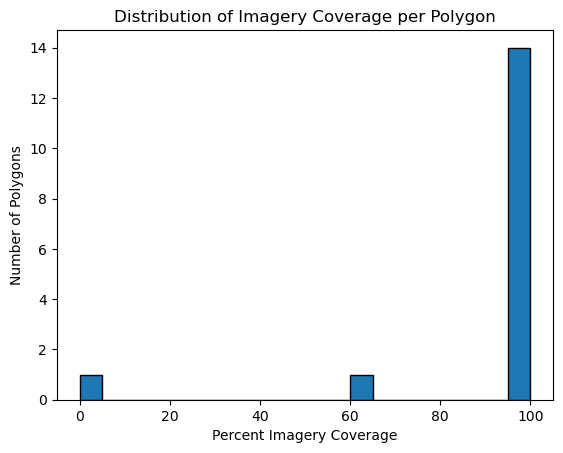

In [26]:
import matplotlib.pyplot as plt

plt.hist(results_df["percent_img_cover"], bins=20, edgecolor="black")
plt.xlabel("Percent Imagery Coverage")
plt.ylabel("Number of Polygons")
plt.title("Distribution of Imagery Coverage per Polygon")
plt.show()

In [42]:
## SAVE OUT RESULTS
today = datetime.today().strftime('%Y-%m-%d')
results_df.to_csv(f"{results_path}polygon_imagery_coverage_{today}.csv")

low_coverage_polygons_df.to_csv(f"{results_path}low_coverage_polygons_{today}.csv")
print("Saved final outputs!")

Saved final outputs!
